# Scenary Classification

In [18]:
import pandas as pd
import numpy as np
import os
import tqdm.auto as tqdm
import cv2
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import random
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,recall_score


In [19]:
device = "cuda"

In [20]:
tranforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(size=(150, 150), antialias=True)
    
])

In [21]:
path = r"C:\Users\rohit\Desktop\machine learning\Datasets\scenary\seg_train\seg_train"
image_path = torchvision.datasets.ImageFolder(path,transform = tranforms)
dir = os.listdir(path)
class_id = list(dir)

In [22]:
path1 = r"C:\Users\rohit\Desktop\machine learning\Datasets\scenary\seg_test\seg_test"
image_path1 = torchvision.datasets.ImageFolder(path,transform = tranforms)

In [23]:
train_load = DataLoader(image_path,
                        batch_size=32,
                        shuffle=True,
                       )

In [24]:
test_load = DataLoader(image_path1,
                        batch_size=32,
                        shuffle=True,
                       )

# Visualisation

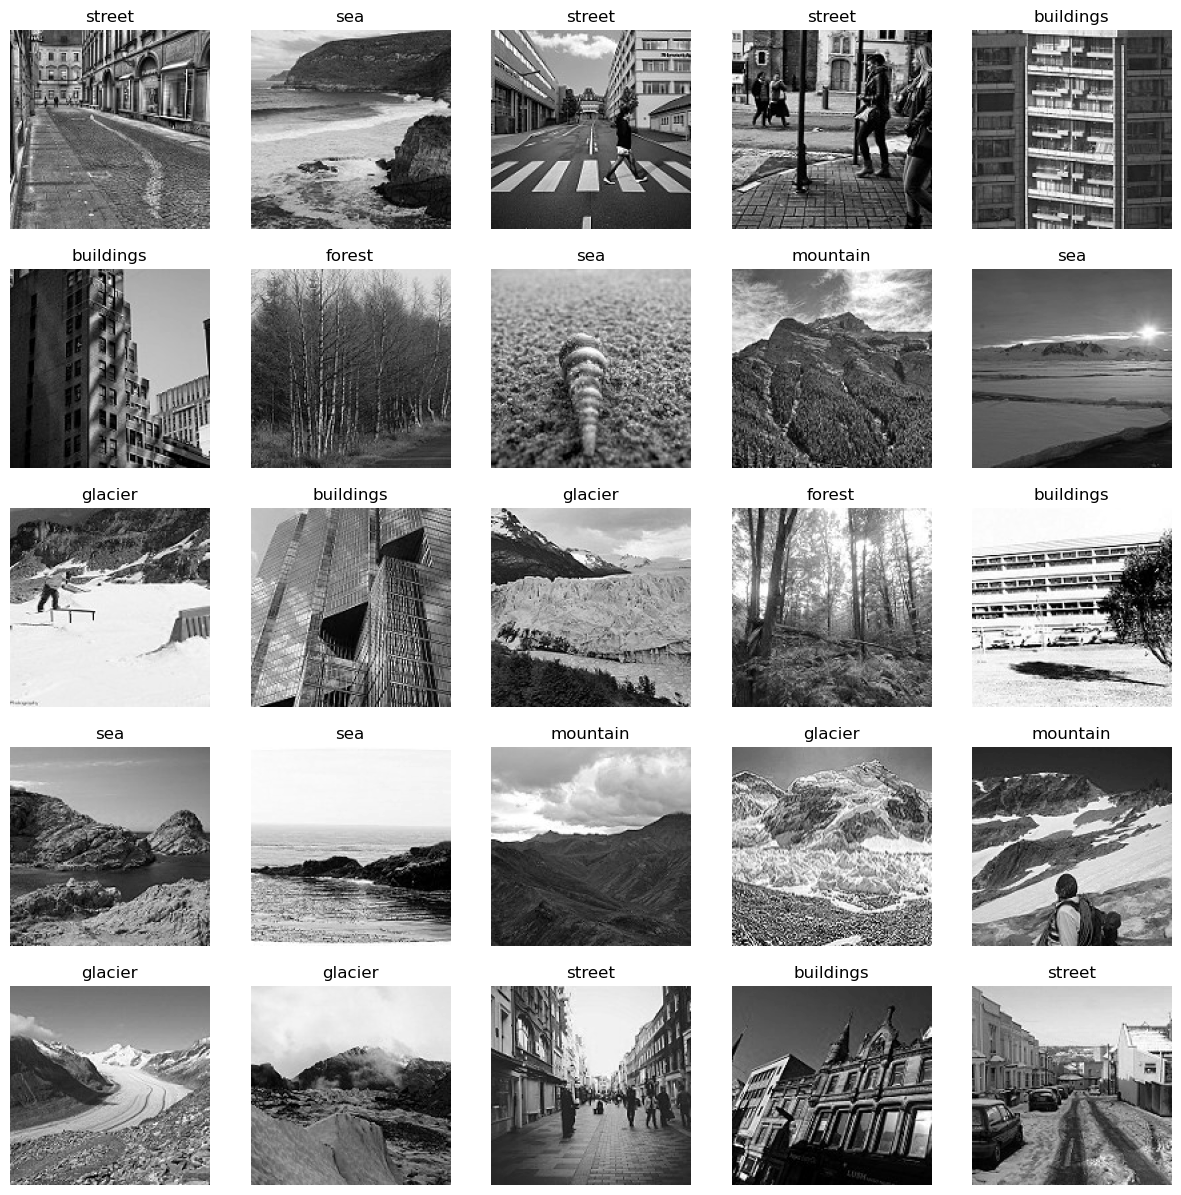

In [31]:
fig = plt.figure(figsize = (15,15))
rows = 5
cols = 5
for i in range(1,26):
    ran = random.randint(0,31)
    label = next(iter(train_load))
    img = label[0][ran]
    target = label[1][ran]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img[1],cmap ="gray")
    plt.title(class_id[target])
    plt.axis(False)
    

In [26]:
img[0].shape

torch.Size([150, 150])

# Model

In [27]:
class mod(nn.Module):
    def __init__(self,input_size:int,hidden_size:int,output_size:int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = input_size,
                      out_channels = hidden_size,
                      kernel_size = (3,3),
                      stride=1,
                      padding=0),
            nn.BatchNorm2d(hidden_size),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels = hidden_size,
                      out_channels = hidden_size,
                      kernel_size = (3,3),
                      stride=1,
                      padding=0),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = (2,2)),
            
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_size,
                      out_channels = hidden_size,
                      kernel_size = (3,3),
                      stride=1,
                      padding=0),
            nn.BatchNorm2d(hidden_size),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels = hidden_size,
                      out_channels = hidden_size,
                      kernel_size = (3,3),
                      stride=1,
                      padding=0),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = (2,2)),
           
        )
        self.conn = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_size*34*34,
                      out_features = output_size),
            nn.LeakyReLU(),
        )


    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.conn(x)
        return x

# Hyperparameters

In [28]:
epoch = 7
lr = 0.001
model = mod(3,12,6).to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

# Training

In [29]:
for i in tqdm(range(epoch)):
    train_loss = 0
    test_acc = 0
    for batch,(x,y) in enumerate(train_load):
        x = x.to(device)
        y = y.to(device)
        model.train()
        logit = model(x)
        cost = loss(logit,y)
        train_loss += cost
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        if batch%200==0:
            print(f"BATCH : {batch}/439")

    for batch,(x,y) in enumerate(test_load):
        x = x.to(device)
        y = y.to(device)
        logit = model(x)
        acc = accuracy_score(y.cpu(),logit.argmax(dim=1).cpu())
        acc = acc*100
        test_acc += acc
    train_loss = train_loss/len(train_load)
    test_acc = test_acc/len(test_load)
    print(f"TRAIN_LOSS : {train_loss}   Test_ACC : {test_acc}")

  0%|          | 0/7 [00:00<?, ?it/s]

BATCH : 0/439
BATCH : 200/439
BATCH : 400/439
TRAIN_LOSS : 1.0560988187789917   Test_ACC : 78.96260440394838
BATCH : 0/439
BATCH : 200/439
BATCH : 400/439
TRAIN_LOSS : 0.5969228148460388   Test_ACC : 86.34285623892686
BATCH : 0/439
BATCH : 200/439
BATCH : 400/439
TRAIN_LOSS : 0.4455796778202057   Test_ACC : 91.56463553530752
BATCH : 0/439
BATCH : 200/439
BATCH : 400/439
TRAIN_LOSS : 0.3432210385799408   Test_ACC : 93.7602822070362
BATCH : 0/439
BATCH : 200/439
BATCH : 400/439
TRAIN_LOSS : 0.24190585315227509   Test_ACC : 95.1183244748165
BATCH : 0/439
BATCH : 200/439
BATCH : 400/439
TRAIN_LOSS : 0.17208395898342133   Test_ACC : 96.14496330043028
BATCH : 0/439
BATCH : 200/439
BATCH : 400/439
TRAIN_LOSS : 0.14400579035282135   Test_ACC : 96.3624715261959


In [30]:
x.dtype

torch.float32